# Disentangled RNNs for Mouse Switching Dataset
The dataset below is from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/7E0NM5). Each row corresponds to a trial, and the columns correspond to the trial number, block position, target direction, choice direction, and reward outcome, as well as the session and mouse identifiers and task conditions.

| Trial | blockTrial | Decision | Switch | Reward | Condition | Target | blockLength | Session | Mouse |
|-------|------------|----------|--------|--------|-----------|--------|-------------|---------|-------|
| 11.0  | 11.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 12.0  | 12.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 13.0  | 13.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |

In [1]:
from src import rnn_utils
from src import disrnn
from src import gru
from src import switch_utils
import optax
from tqdm.auto import tqdm
from datetime import datetime
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import jax
import jax.numpy as jnp
import haiku as hk

## Training

In [ ]:
hidden_size = 1
target_size = 2
obs_size = 2

def create_gru():
    return gru.HkGRU(hidden_size=hidden_size, target_size=target_size)

# Setup optimizer
optimizer = optax.adam(learning_rate=1e-3)

# Run training
key = jax.random.PRNGKey(0)
trained_params, final_opt_state, loss_results = gru.train_gru_network(
    make_network=create_gru,
    training_dataset=ds_tr,
    validation_dataset=ds_va,
    opt=optimizer,
    random_key=key,
    n_steps=10000,
    max_grad_norm=1.0,
    do_plot=True
)

print("Training complete.")
print(f"Final validation loss: {loss_results['validation_loss'][-1]}")


In [ ]:
var = next(ds_tr)[1]
print(np.unique(var, return_counts=True), np.shape(var))

In [ ]:
import jax.numpy as jnp
import haiku as hk



def unroll_network(xs):
  core = create_gru()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk = hk.transform(unroll_network)
step_hk = jax.jit(step_hk)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output = step_hk(trained_params, None, ds_va._xs)[:,:,:2]
# sample from the output either greedily or with thompson sampling
sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type)

# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled[:-1,:], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color='g', alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf')
plt.show()

In [ ]:
"""
Iterate through the mice, and through the beta values, saving the trained
params and loss for each in a json to disk.
"""
# betas = [1e-3]
betas = [1e-3, 3e-3, 1e-2, 3e-2]
n_steps = 1e4

n_calls = len(betas)
dt = datetime.now().strftime("%Y-%m-%d_%H-%M")
print(f"start time: {dt}")
switch_utils.split_saver(tr_eps, va_eps, dt, train_prop)
with tqdm(total=n_calls, desc='Overall Progress', position=1) as outer_bar:
  for beta_j in betas:
    outer_bar.set_postfix(beta=f"{beta_j:.0e}")
    params, opt_state, losses = rnn_utils.train_network(
    make_network,
        ds_tr,
        ds_va,
        ltype_tr="penalized_categorical",
        opt = optax.adam(learning_rate),
        penalty_scale = beta_j,
        n_steps=n_steps,
        do_plot = False)
    switch_utils.model_saver(params, beta_j, dt=dt, loss=losses, train_prop=train_prop)
    outer_bar.update(1)


## Analysis
From here on, you can load models from disk for each mouse as trained above.

In [2]:
data_dir = '/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/data/processed'
model_dir = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

# choose mouse, beta and run time
model_name = 'disrnn'
train_prop = 0.7
param = 0.01
cv = f'{train_prop*100:.0f}-{(1-train_prop)*100:.0f}'
train_dt = "2025-04-18_00-24"
split_dt = "2025-04-17_10-28"
batch_size = 64

model_shape = {'dis_latent_size': 5,
                'tiny_latent_size': 2,
                'update_mlp_shape': (5,5,5),
                'choice_mlp_shape': (2,2),
                'obs_size': 2,
                'target_size': 2}

param_dict = {'disrnn': f'{param:.0e}', 'rnn': f'{param}'}
params_file = os.path.join(model_dir, f"params_{model_name}_{param_dict[model_name]}_{cv}_{train_dt}.json")

df_tr = pd.read_csv(os.path.join(data_dir, f"train_df_{cv}_{split_dt}.csv"))
df_va = pd.read_csv(os.path.join(data_dir, f"validation_df_{cv}_{split_dt}.csv"))

params = switch_utils.model_loader(params_file=params_file)

ds_tr = switch_utils.get_dataset(df_tr, batch_size)
ds_va = switch_utils.get_dataset(df_va, batch_size)

def model_factory(model_name, model_shape):
    if model_name == 'disrnn':
        def make_network_eval():
            return disrnn.HkDisRNN(update_mlp_shape=model_shape['update_mlp_shape'],
                                    choice_mlp_shape=model_shape['choice_mlp_shape'],
                                    latent_size=model_shape['dis_latent_size'],
                                    obs_size=model_shape['obs_size'], 
                                    target_size=model_shape['target_size'],
                                    eval_mode=True)
    else: 
        def make_network_eval():
            return gru.HkGRU(hidden_size=model_shape['tiny_latent_size'], 
                             target_size=model_shape['target_size'])
    return make_network_eval

make_network_eval = model_factory(model_name, model_shape)


## Switching Analysis
Here I will check how the RNN models from above behave from a switching perspective. This is based on the comparisons from the paper:

    Beron, C. C., Neufeld, S. Q., Linderman, S. W., & Sabatini, B. L. (2022). Mice exhibit stochastic and efficient action switching during probabilistic decision making. Proceedings of the National Academy of Sciences, 119(15), e2113961119. https://doi.org/10.1073/pnas.2113961119


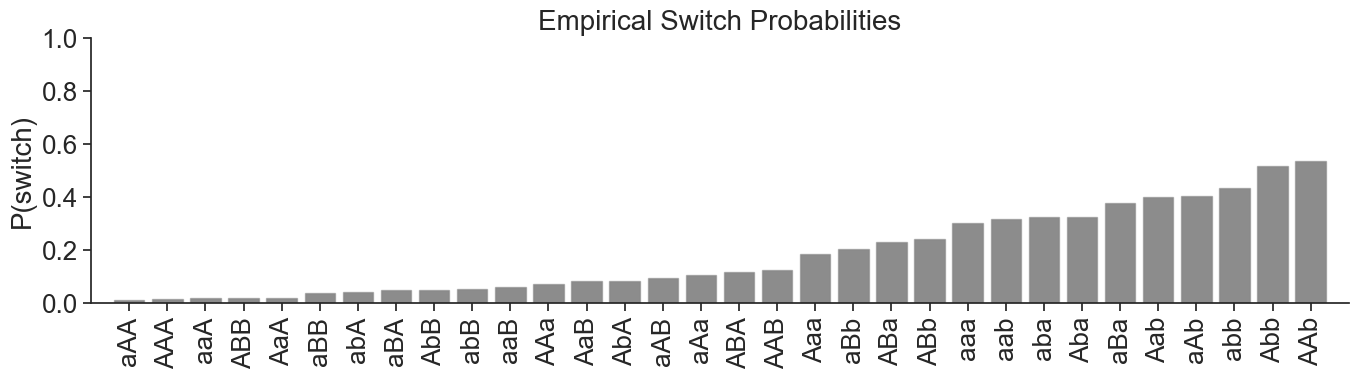

In [3]:

p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray')
ax.errorbar(x=sorted_labels, y=sorted_heights, fmt=' ', color='k', label=None)

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Empirical Switch Probabilities')
plt.tight_layout()

In [4]:
def unroll_network(xs):
  core = make_network_eval()
  batch_size = jnp.shape(xs)[1]
  state = core.initial_state(batch_size)
  ys, _ = hk.dynamic_unroll(core, xs, state)
  return ys


_, step_hk = hk.transform(unroll_network)
step_hk = jax.jit(step_hk)

random_key = jax.random.PRNGKey(0)

# first two columns give the probability of left and right (but need to be put through
# softmax for normalising)
output = step_hk(params, random_key, ds_va._xs)[:,:,:2]
# sample from the output either greedily or with thompson sampling
sample_type = 'thompson'
y_sampled = switch_utils.sampler(output, sample_type)
ll = switch_utils.log_likelihood_normalised(ds_va._ys, output)
print(f"The log likelihood for {model_name} is {ll:.3f}.")

The log likelihood for disrnn is -0.200.


In [7]:
jax.nn.softmax(output[:100,1])

Array([[0.46128833, 0.53871167],
       [0.9616867 , 0.03831338],
       [0.9791445 , 0.02085548],
       [0.9838545 , 0.01614552],
       [0.98549193, 0.01450808],
       [0.98612463, 0.01387543],
       [0.9863799 , 0.01362006],
       [0.9864849 , 0.01351507],
       [0.9865284 , 0.0134716 ],
       [0.9865465 , 0.01345353],
       [0.94899297, 0.05100709],
       [0.9767486 , 0.02325136],
       [0.98310214, 0.01689784],
       [0.93807983, 0.06192017],
       [0.9760189 , 0.02398107],
       [0.9168891 , 0.08311091],
       [0.82680374, 0.17319621],
       [0.09890038, 0.90109956],
       [0.02747134, 0.97252864],
       [0.01591676, 0.98408324],
       [0.01269963, 0.98730034],
       [0.01157226, 0.9884277 ],
       [0.01113831, 0.98886174],
       [0.01096473, 0.9890352 ],
       [0.01089421, 0.98910576],
       [0.01086536, 0.98913467],
       [0.01085353, 0.9891465 ],
       [0.01084868, 0.98915136],
       [0.01084669, 0.9891533 ],
       [0.09474104, 0.905259  ],
       [0.

In [ ]:
# simulated conditional probability dictionary for each 3 letter history
p_dict = switch_utils.switch_bars(ds_va._xs, ds_va._xs[:,:,0], symm=True, prob=True)
sim_p_dict = switch_utils.switch_bars(ds_va._xs[1:], y_sampled[:-1,:], symm=True, prob=True)

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_keys = [item[0] for item in sorted_items] 
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
sim_sorted_heights = [sim_p_dict[key] for key in sorted_keys]

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sim_sorted_heights, color='g', alpha=1, ax=ax, label='DisRNN Switch Prob')
sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray', label='Mouse Switch Prob')

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.title('Conditional Switch Probabilities')
plt.tight_layout()
plt.legend()
plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/switch_probs.pdf')
plt.show()

In [ ]:
sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18})   
sns.set_palette('dark')

plt.figure(figsize=(4,4))
plt.subplot(111, aspect='equal')
plt.scatter(sorted_heights, sim_sorted_heights, color='green', alpha=0.6, edgecolor=None, linewidth=0)
plt.plot([0, 1], [0, 1], ':k')

plt.xlabel('P(switch)$_{mouse}$')
plt.ylabel('P(switch)$_{DisRNN}$')
plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(0, 1.1, 0.5))

plt.tight_layout()
sns.despine()

plt.savefig('/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/figs/scatter_disrnn_v_mouse.pdf')
plt.show()

In [ ]:
"""
Next, I need to line up the block index in each trial with the switches as
calculated by the samplers.
"""

# ds_va = switch_utils.get_dataset(df[df['Session'].isin(va_eps.index)], va_eps, batch_size)
blocks_sim = switch_utils.blocker(df_va, 10, 20, y_sampled)
blocks = switch_utils.blocker(df_va, 10, 20, ds_va._xs[:,:,0])
block_pos = np.arange(-10,20)
blocks_sim_high = blocks_sim[:,:,:,0] == blocks_sim[:,:,:,1]
blocks_high = blocks[:,:,:,0] == blocks[:,:,:,1]

sns.set_theme(style='ticks', font_scale=1.6, rc={'axes.labelsize':18, 'axes.titlesize':18}) 

fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.vlines(x=0,ymin=0,ymax=1.05,linestyle='dotted',color='black')
    
ax1.plot(block_pos, np.mean(blocks_sim_high[:,:,2], axis=1),label='DisRNN', alpha=0.8, linewidth=3, color=sns.color_palette()[2])
ax1.plot(block_pos, np.mean(blocks_high[:,:,2], axis=1),label='mouse', alpha=0.8, linewidth=3, color=sns.color_palette()[0])

ax1.set_yticks([0,0.5, 1.0])
ax1.legend(fontsize=16,frameon=False)
ax1.set(xlim=(-10,20), ylim=(0,1), xlabel='Block Position', ylabel='P(high port)')

sns.despine()

In [ ]:
(ds_va._ys[4:]) / 